In [2]:

from pathlib import Path
import math
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.io import loadmat
from scipy.signal import welch


plt.rcParams['figure.dpi'] = 120


# Mokuleia Sensor 1 Wave Analysis

The goal here is to mirror the plots in 'PILOTmokuleia.pdf', given a SBE bottom-mounted pressure sensor, sensor 1. Sensor 1 is the closest to shore at 1.3m depth. 


## Load the raw pressure bursts
`MoA18411.mat` stores 12-hour bursts of 1 Hz pressure (`pclip`, in psi) and MATLAB datenums (`tclip`). Every 12 hours there is a 20 second download gap that we will reinsert so the timeline is continuous.


In [10]:

raw = loadmat(Path('/Users/isidorarojas/Desktop/DIRECTORY/2025/reef_runup/mokuleia/MoA18411.mat'))
raw.keys()

dict_keys(['__header__', '__version__', '__globals__', 'pclip', 'tclip', 'thres'])

In [11]:
pclip = np.asarray(raw['pclip'], dtype=float)  # absolute pressure in psi
tclip = np.asarray(raw['tclip'], dtype=float)  # MATLAB datenums
pclip.shape, tclip.shape


((43180, 184), (43180, 184))


### Convert pressure to surface-tracking depth

$$h = \frac{p_{\text{gauge}}}{\rho g}. $$


- Convert psi to Pa, subtract atmospheric pressure and then to meters by the equation:

$$h = \frac{p_{\text{gauge}}}{\rho g}. $$

- insert NaNs after the 12 hours burst for the 20 s storage gaps to keep time regular

- Convert to NumPy datetimes using $t_{\text{unix days}} = t_{\text{matlab}} - 719529.$ 



In [12]:
# parameters
RHO_SEAWATER = 1025.0
G = 9.81
GAP_SAMPLES = 20

nsamp, nburst = pclip.shape # pclip (samples, bursts)
block_len = nsamp + GAP_SAMPLES # length of each burst + gap

# convert to pressure in Pa
pgauge_pa = (pclip - 14.7) * 6895.0

# reshape to 1D time series with a gap inbetween bursts 
stack = np.full((block_len, nburst), np.nan)
stack[:nsamp, :] = pgauge_pa
pressure_pa = stack.reshape(-1, order='F')[:-GAP_SAMPLES]

# hydrostatic depth in m 
depth_stack = np.full((block_len, nburst), np.nan)
depth_stack[:nsamp, :] = pgauge_pa / (RHO_SEAWATER * G)
depth_m = depth_stack.reshape(-1, order='F')[:-GAP_SAMPLES]

# create time vector in datenum format
seconds = np.arange(pressure_pa.size, dtype=float)
mat_time = tclip[0, 0] + seconds / 86400.0

# MATLAB datenum -> numpy datetime64[ns]
datetime64 = (mat_time - 719529.0) * 86400.0 * 1e9
ns_since_unix = np.round(datetime64).astype('int64')
base = np.datetime64('1970-01-01T00:00:00')
time = base + ns_since_unix.astype('timedelta64[ns]')

time[:3], pressure_pa[:3], depth_m[:3]


(array(['2007-12-14T12:00:01.000004608', '2007-12-14T12:00:02.000009216',
        '2007-12-14T12:00:03.000003840'], dtype='datetime64[ns]'),
 array([14241.96725 , 13544.586265, 13450.11787 ]),
 array([1.41637127, 1.34701636, 1.33762143]))

#### A digression on using the hydrostatic balance

In essense, I am trying to pull out the slow, quasi-stationary part of the water column. Thus, the result should include MSL, tides, slowly varying wave setup, IG waves. 


## Remove the tidal signal with a moving mean
Waves ride on top of a slowly varying tide. Separate the two by applying:

- a centred moving average (1 h window) for the tide, and
- a shorter moving average (10 min window) for the pressure trend before high-pass filtering.

For a series $x_i$ the NaN-aware moving average over window width $W$ is
9
$$\bar{x}_i = \frac{\sum_{j=i-W/2}^{i+W/2} w_j x_j}{\sum_{j=i-W/2}^{i+W/2} w_j},$$

where $w_j = 1$ if the sample is finite and $0$ otherwise.


<span style="color:red">Is a 1h window sufficient for the tide?</span>.



In [13]:

# windowed moving average that ignores NaNs, where windows are time-centered

def moving_average_nan(x: np.ndarray, window: int) -> np.ndarray:
    if window < 1:
        raise ValueError('window must be >= 1')
    kernel = np.ones(window)
    valid = np.isfinite(x).astype(float) # 0 where NaN, 1 where valid. 
    filled = np.where(np.isfinite(x), x, 0.0)
    num = np.convolve(filled, kernel, mode='same')
    den = np.convolve(valid, kernel, mode='same')
    out = np.full_like(x, np.nan, dtype=float)
    mask = den > 0
    out[mask] = num[mask] / den[mask]
    return out

TIDE_WINDOW = 3600   # 1 hour at 1 Hz
WAVE_WINDOW = 600    # 10 minutes at 1 Hz

depth_tide = moving_average_nan(depth_m, TIDE_WINDOW)
pressure_trend = moving_average_nan(pressure_pa, WAVE_WINDOW)
pressure_hp = pressure_pa - pressure_trend

depth_tide[:3], pressure_hp[:3]


(array([1.46064049, 1.46062949, 1.46059806]),
 array([ -325.05916707, -1020.18818581, -1114.96919422]))

In [40]:
depth_m.min()

nan

## Inspect filter responses
The FFT of each boxcar window reveals the frequency band each moving average actually passes. I plot the magnitude response of the 1-hour and 10-minute windows to make sure the cutoffs sit where we expect.

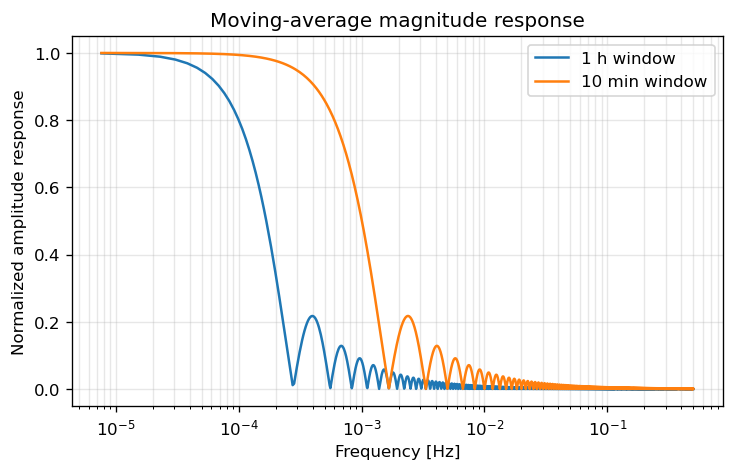

In [14]:
from numpy.fft import rfft, rfftfreq

def window_response(window, dt=1.0, nfft=131072):
    w = np.ones(window) / window          # boxcar weights
    nfft = max(nfft, 4 * window)          # make sure we oversample in frequency
    resp = np.abs(rfft(w, n=nfft))
    freqs = rfftfreq(nfft, d=dt)
    return freqs[1:], (resp / resp[0])[1:]  # drop the DC bin

freq_tide, resp_tide = window_response(TIDE_WINDOW)
freq_wave, resp_wave = window_response(WAVE_WINDOW)

fig, ax = plt.subplots(figsize=(7, 4))
ax.semilogx(freq_tide, resp_tide, label='1 h window')
ax.semilogx(freq_wave, resp_wave, label='10 min window')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Normalized amplitude response')
ax.set_title('Moving-average magnitude response')
ax.grid(True, which='both', alpha=0.3)
ax.legend()
plt.show()



*Asked ChatGPT about disseminating the spectra above*

Picture the blue and orange curves as “frequency-domain lenses” created by each moving average. A moving average is just a convolution with a boxcar, and the Fourier transform of a boxcar is a sinc, so you get a low‑pass response that starts near 1 (passes those frequencies almost unchanged) and then drops to zero at the first null, with oscillatory sidelobes beyond.

The x-axis is frequency in Hz (cycles per second). For reference, 10⁻⁴ Hz ≈ a period of 2.8 hours; 10⁻³ Hz ≈ 17 minutes; 10⁻² Hz ≈ 100 seconds.

The left-hand plateau near 1.0 means the moving average leaves those very-low frequencies almost untouched.

The first big drop marks the effective cutoff set by the window length. The first zero of the sinc is at f ≈ 1/window_length (in seconds):

Blue (1 h window) first zero around 1/3600 ≈ 2.8×10⁻⁴ Hz → it keeps tides, setup, and other variations slower than ~1 hour, while suppressing faster motions (waves).
Orange (10 min window) first zero around 1/600 ≈ 1.7×10⁻³ Hz → it keeps motions slower than ≈10 minutes and damps things faster than that.
The ripples to the right are sidelobes of the sinc; they show that a pure boxcar doesn’t have a perfectly sharp cutoff. Energy just beyond the nominal cutoff leaks through (with decreasing amplitude). That’s normal for moving averages.

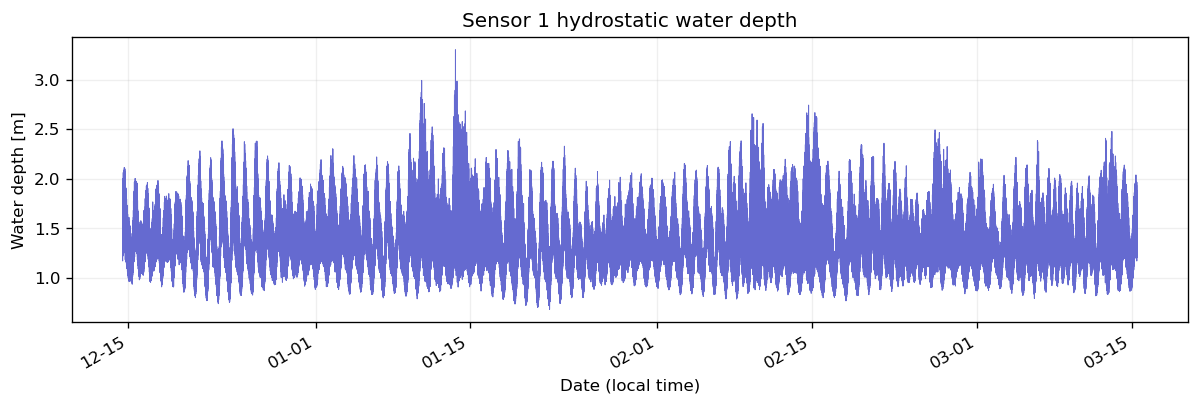

In [16]:

def to_datetime(arr):
    arr = np.asarray(arr, dtype='datetime64[ns]')
    return arr.astype('datetime64[ms]').astype(object).tolist()

time_py = to_datetime(time)

fig, ax = plt.subplots(figsize=(12, 3.5))
ax.plot(time_py, depth_m, linewidth=0.6, color="#656AD0", label='Depth (m)')
ax.set_ylabel('Water depth [m]')
ax.set_xlabel('Date (local time)')
ax.set_title('Sensor 1 hydrostatic water depth')
ax.grid(True, alpha=0.2)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
fig.autofmt_xdate()
plt.show()



## Spectral method review
Estimate wave energy with Welch-style sliding spectra (because there is a function for it that is easy to use):

1. Segment the high-passed pressure into overlapping windows (~30 min with 50% overlap).
2. Apply a Hann taper and compute the FFT.
3. Convert pressure spectra $S_{pp}(f)$ to surface elevation spectra $S_{\eta\eta}(f)$ using the linear transfer function from Falk's *Notes on 
Nearshore Physical Oceanography (Chapter 8)*
$$S_{\eta\eta}(f) = \left[\frac{\cosh(k(f) h)}{\rho g}\right]^2 S_{pp}(f),$$

where the wavenumber $k$ satisfies the dispersion relation $\omega^2 = g k \tanh(k h)$.

4. Integrate $S_{\eta\eta}$ to obtain significant wave height $H_s = 4\sqrt{m_0}$ over different frequency bands (sea/swell and infragravity), and record the sea/swell peak period $T_p = 1 / f_p$.


Falk's notes defines the sea-swell frequency band as $0.05<f<0.03 Hz$


In [41]:
# ------ Helpers ---------

# interpolate NaNs in a 1D array
def nan_interp(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, dtype=float)
    out = x.copy()
    bad = ~np.isfinite(out)
    if not np.any(bad):
        return out
    idx = np.arange(out.size)
    good = ~bad
    out[bad] = np.interp(idx[bad], idx[good], out[good])
    return out

# compute wavenumber from frequency and Newton's method
def wavenumber(omega: np.ndarray, depth: float, tol: float = 1e-12, max_iter: int = 64) -> np.ndarray:
    omega = np.asarray(omega, dtype=float)
    k = np.zeros_like(omega)
    if depth <= 0.0:
        return k
    mask = omega > 0.0
    if not np.any(mask):
        return k
    k_mask = (omega[mask] ** 2) / G  # deep-water initial guess
    for _ in range(max_iter):
        kh = k_mask * depth
        tanh_kh = np.tanh(kh)
        cosh_kh = np.cosh(kh)
        sech2 = 1.0 / (cosh_kh ** 2)
        f = G * k_mask * tanh_kh - omega[mask] ** 2
        df = G * tanh_kh + G * depth * k_mask * sech2
        step = np.divide(f, df, out=np.zeros_like(f), where=df != 0.0)
        k_next = k_mask - step
        if np.nanmax(np.abs(step)) < tol:
            break
        k_mask = np.where(np.isfinite(k_next), k_next, k_mask)
    k[mask] = k_mask
    return k


In [42]:
def compute_sliding_spectra(pressure_hp: np.ndarray, depth_lp: np.ndarray, dt: float = 1.0,
                             win_len: int = 2048, step: int = 1024):
    
    ''' 
    Compute sliding-window wave spectra from high-pass filtered pressure
    pressure_hp: high-pass filtered pressure time series (Pa)
    depth_lp: low-pass filtered depth time series (m)
    dt: sampling interval (s)
    win_len: window length (samples)
    step: step size between windows (samples)
    '''
    pressure_hp = nan_interp(pressure_hp) 
    depth_lp = nan_interp(depth_lp)
    n = pressure_hp.size
    # n - win_len + 1 to ensure theres at least one full window 
    starts = np.arange(0, n - win_len + 1, step, dtype=int)
    # apply Hannning window with energy normalization
    hann = np.hanning(win_len)
    hann *= math.sqrt(win_len / np.sum(hann ** 2))

    # define frequency and angular frequency arrays
    freqs = np.fft.rfftfreq(win_len, d=dt)
    omega = 2 * np.pi * freqs

    # initialize output lists 
    spectra = []
    hs_total = []
    hs_ss = []
    hs_ig = []
    tp_ss = []
    t_mid = []

    # define frequency bands
    mask_total = freqs > 0.0
    mask_ss = (freqs >= 0.04) & (freqs <= 0.20)
    mask_ig = (freqs >= 0.004) & (freqs <= 0.04)

    # loop over windows and compute spectra 
    for start in starts:
        stop = start + win_len         
        seg = pressure_hp[start:stop]
        depth_seg = depth_lp[start:stop]
        if np.any(~np.isfinite(seg)):
            continue
        fs = 1.0
        seg = seg - np.mean(seg)
        seg *= hann

        # compute energy density spectrum 
        X = np.fft.rfft(seg)
        U = np.sum(hann ** 2)           # window energy
        # one sided spectrum 
        Spp = (np.abs(X) ** 2) / (fs * U)
        Spp[1:-1] *= 2.0                       # undo doubling at DC
        # correct for even window length      
        if win_len % 2 == 0:
            Spp[-1] *= 0.5 
    
        h_eff = float(np.nanmean(depth_seg))
        # compute transfer function ffom bottom to sfc 
        k = wavenumber(omega, h_eff)
        transfer = np.cosh(k * h_eff) / (RHO_SEAWATER * G)
        Seta = (transfer ** 2) * Spp
        spectra.append(Seta)


        def m0(mask):
            ''' integrates the sfc elevation spectrum over a freq band to 
            get the zeroth spectral moment
            
            Return: band-integrated spectral variance (m0)'''
            if not np.any(mask):
                return 0.0
            return float(np.trapz(Seta[mask], freqs[mask]))

        m0_total = m0(mask_total)
        m0_ss = m0(mask_ss)
        m0_ig = m0(mask_ig)

        # compute significant wave heights and peak periods 
        hs_total.append(4.0 * math.sqrt(max(m0_total, 0.0)))
        hs_ss.append(4.0 * math.sqrt(max(m0_ss, 0.0)))
        hs_ig.append(4.0 * math.sqrt(max(m0_ig, 0.0)))

        if np.any(mask_ss) and np.nanmax(Seta[mask_ss]) > 0.0:
            fp = freqs[mask_ss][np.nanargmax(Seta[mask_ss])]
            tp_ss.append(1.0 / fp if fp > 0 else np.nan)
        else:
            tp_ss.append(np.nan)

        t_mid.append(time[start + win_len // 2])

    result = {
        'freqs': freqs,
        'spectra': np.vstack(spectra),
        'time_centers': np.array(t_mid),
        'hs_total': np.array(hs_total),
        'hs_ss': np.array(hs_ss),
        'hs_ig': np.array(hs_ig),
        'tp_ss': np.array(tp_ss),
    }
    return result

spectral_summary = compute_sliding_spectra(
    pressure_hp,
    depth_tide,
    dt=1.0,
    win_len=int(43180/4),   # 3 h at 1 Hz
    step=21590 /4    # one value per burst; use 21590 for 50% overlap
)

{key: arr.shape for key, arr in spectral_summary.items() if hasattr(arr, 'shape')}


{'freqs': (5398,),
 'spectra': (1471, 5398),
 'time_centers': (1471,),
 'hs_total': (1471,),
 'hs_ss': (1471,),
 'hs_ig': (1471,),
 'tp_ss': (1471,)}

In [43]:
pressure_pa.shape

(7948780,)


## Significant wave height vs time
integrate the surface spectra over all frequencies and over specific bands:
- *Sea/swell* (0.05–0.33 Hz)
- *Infragravity* (0.004–0.04 Hz)

Each series is plotted with the window centre times.


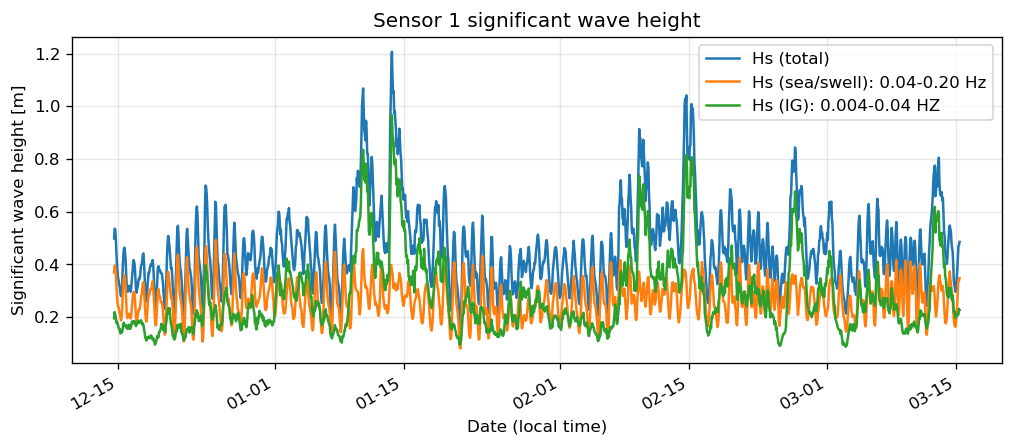

In [34]:

time_mid = to_datetime(spectral_summary['time_centers'])

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(time_mid, spectral_summary['hs_total'], label='Hs (total)')
ax.plot(time_mid, spectral_summary['hs_ss'], label='Hs (sea/swell): 0.04-0.20 Hz')
ax.plot(time_mid, spectral_summary['hs_ig'], label='Hs (IG): 0.004-0.04 HZ')
ax.set_ylabel('Significant wave height [m]')
ax.set_xlabel('Date (local time)')
ax.set_title('Sensor 1 significant wave height')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
fig.autofmt_xdate()
plt.show()



## Sea/swell peak period
For each window we identify the frequency of maximum spectral density inside the sea/swell band and convert it to period.


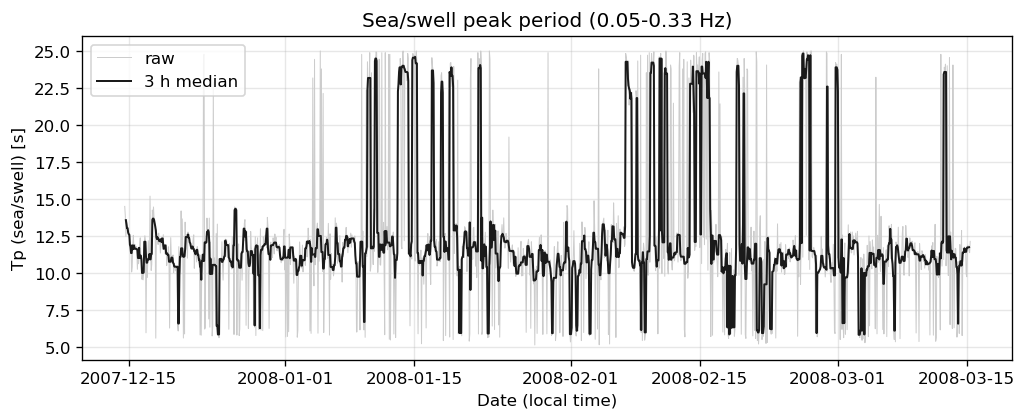

In [35]:
def running_median(x, n):
    """Odd-length window rolling median; pads ends with NaN."""
    x = np.asarray(x, float)
    out = np.full_like(x, np.nan)
    k = n // 2
    for i in range(k, len(x) - k):
        out[i] = np.nanmedian(x[i - k:i + k + 1])
    return out

tp_raw = spectral_summary['tp_ss']
tp_med = running_median(tp_raw,  5)  # ~3 hr smoothing at ~17 min steps

fig, ax = plt.subplots(figsize=(10, 3.5))
ax.plot(time_mid, tp_raw, color='0.8', linewidth=0.6, label='raw')
ax.plot(time_mid, tp_med, color='0.1', linewidth=1.2, label='3 h median')
ax.set_ylabel('Tp (sea/swell) [s]')
ax.set_xlabel('Date (local time)')
ax.set_title('Sea/swell peak period (0.05-0.33 Hz)')
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()



## Median surface elevation spectrum
Taking the median spectrum across all windows gives a representative shape of the energy distribution across frequencies.


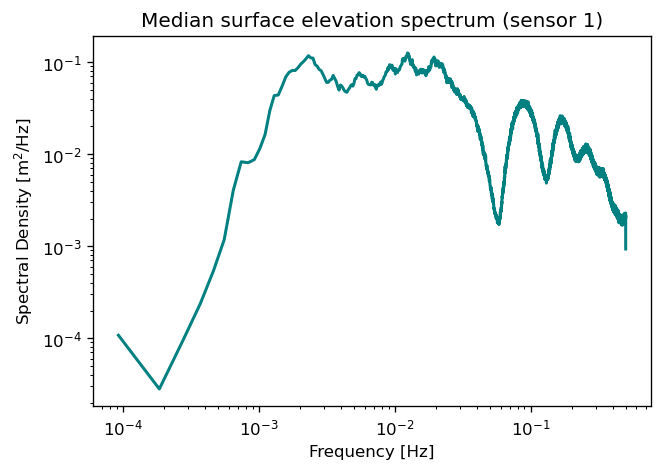

In [36]:
median_spec = np.nanmedian(spectral_summary['spectra'], axis=0)
freqs = spectral_summary['freqs']

fig, ax = plt.subplots(figsize=(6, 4))
ax.loglog(freqs[1:], median_spec[1:], lw=1.8, color='teal')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Spectral Density [m$^2$/Hz]')
ax.set_title('Median surface elevation spectrum (sensor 1)')

plt.show()


Total water level (TWL) superposes wave effects on SWL, the still water level without waves. (Fiedler 2020)

That is, $TWL = R_{2} + SWL$

In [37]:

def interp_to_full(series_key):
    full_time_seconds = (time - time[0]).astype('timedelta64[s]').astype(float)
    t_mid_seconds = (spectral_summary['time_centers'] - spectral_summary['time_centers'][0])\
    .astype('timedelta64[s]').astype(float)
    return np.interp(full_time_seconds, t_mid_seconds, spectral_summary[series_key])

hs_total_full = interp_to_full('hs_total')
hs_ss_full = interp_to_full('hs_ss')
hs_ig_full = interp_to_full('hs_ig')


# 20-minute running mean water level (tide + setup envelope).
MEAN_WIN = 20 * 60  # samples at 1 Hz
depth_series = pd.Series(depth_m)
mean_level_20 = depth_series.rolling(window=MEAN_WIN, center=True, min_periods=MEAN_WIN//2).mean().to_numpy()
mean_level_20 = mean_level_20 - np.nanmean(mean_level_20) # remove the depth of the sensor

# 20-minute high water level as the sum of mean level + half sig wave height
high_level_20 = mean_level_20 + (0.5 * hs_total_full)

# setup
setup = hs_total_full**2 / (16 * depth_tide)

# Unsure of how to compute extreme water level
extreme_level = high_level_20 + setup          

A_ig = 0.5 * hs_ig_full                                     # amplitude ~ Hs/2 for IG band
A_ss = 0.5 * hs_ss_full                                     # amplitude ~ Hs/2 for sea/swell

# 5) Shared datetime axis.
time_py = to_datetime(time)



$\eta_{\text{setup}} \approx \frac{S_{xx,\text{off}} - S_{xx,\text{shore}}}{\rho g h}
= \frac{H_s^2}{16,h}$

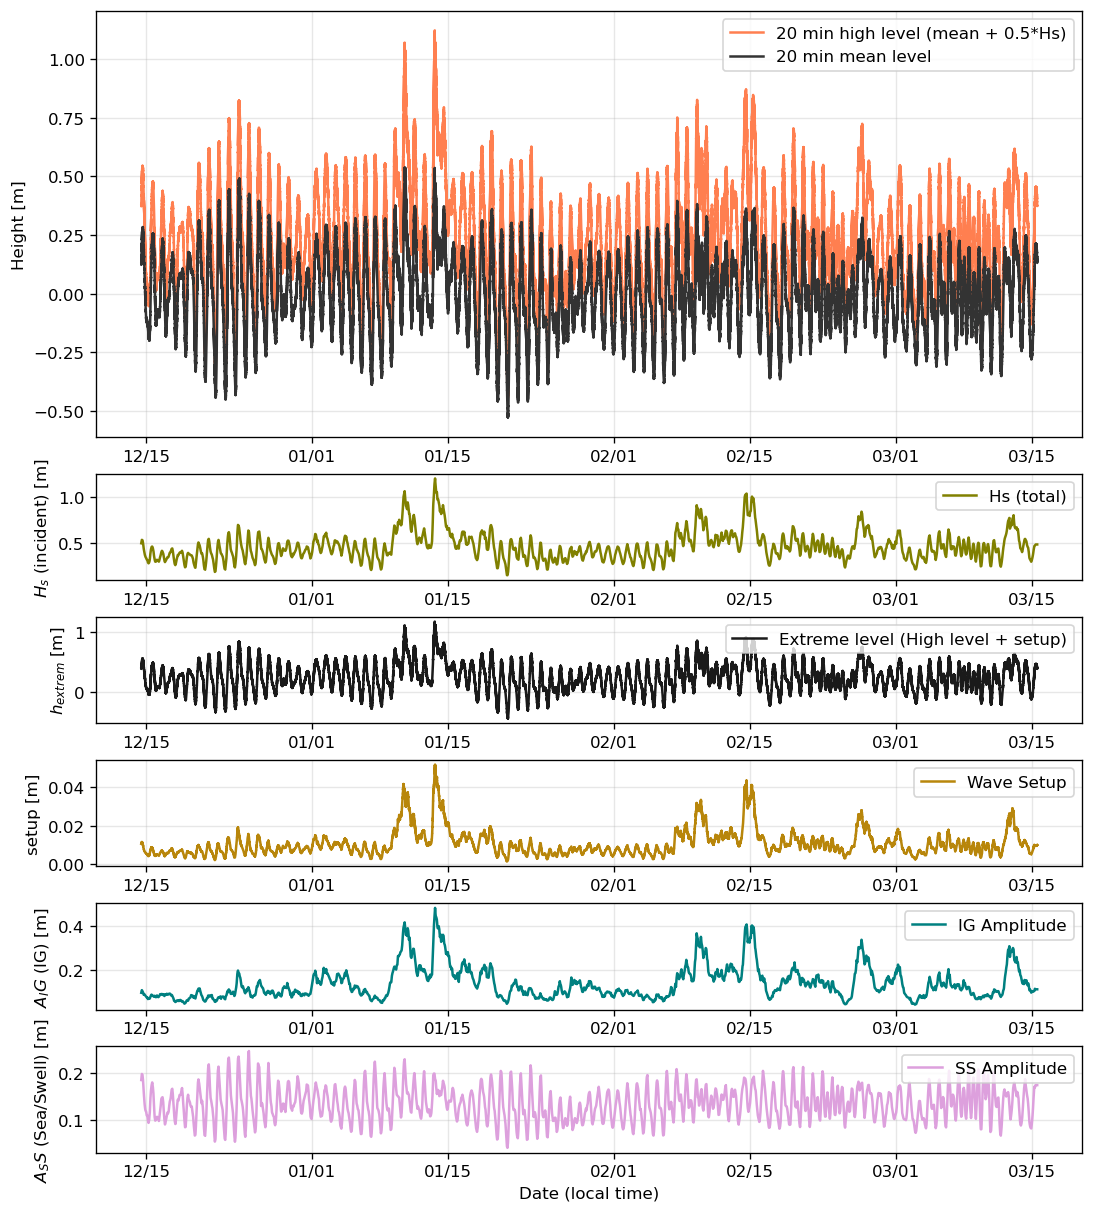

In [38]:
# Build stacked panels.
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(9, 10), sharex=False, constrained_layout=True, gridspec_kw={'height_ratios': [4, 1, 1, 1, 1, 1]})

# how to compute high level? seems like mean level + wave height?
axes[0].plot(time_py, high_level_20, color='coral', label='20 min high level (mean + 0.5*Hs)')
axes[0].plot(time_py, mean_level_20, color='0.2', label='20 min mean level')
axes[0].set_ylabel('Height [m]')
axes[0].legend(loc='upper right')

axes[1].plot(time_py, hs_total_full, color='olive', label='Hs (total)')
axes[1].set_ylabel(r'$H_s$ (incident) [m]')
axes[1].legend(loc='upper right')


axes[2].plot(time_py, extreme_level, color='0.1', label = 'Extreme level (High level + setup)')
axes[2].set_ylabel(r'$h_{extrem}$ [m]')
axes[2].legend(loc='upper right')

axes[3].plot(time_py, setup, color='darkgoldenrod', label = 'Wave Setup')
axes[3].set_ylabel(r'setup [m]')
axes[3].legend(loc='upper right')

axes[4].plot(time_py, A_ig, color='teal', label="IG Amplitude")
axes[4].set_ylabel(r'$A_IG$ (IG) [m]')
axes[4].legend(loc='upper right')

axes[5].plot(time_py, A_ss, color='plum', label = "SS Amplitude")
axes[5].set_ylabel(r'$A_SS$ (Sea/Swell) [m]')
axes[5].set_xlabel('Date (local time)')
axes[5].legend(loc='upper right')


for ax in axes:
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

plt.show()


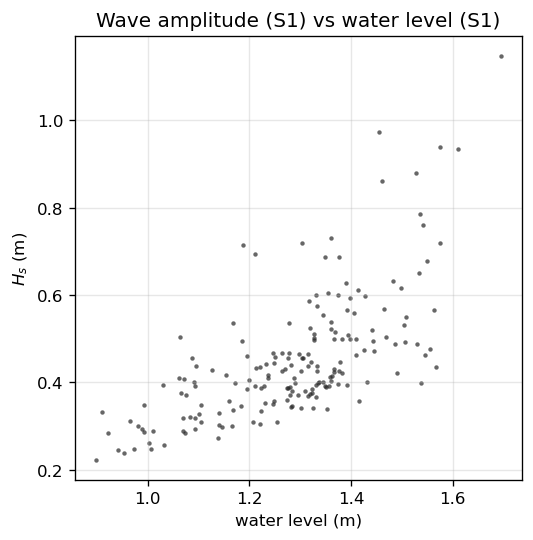

In [ ]:
# --- Scatter: incident Hs versus 20-min mean water level ---
# Interpolate mean water level onto the spectral window centres.
full_time_seconds = (time - time[0]).astype('timedelta64[s]').astype(float)
t_mid = spectral_summary['time_centers']
if np.issubdtype(t_mid.dtype, np.datetime64):
    t_mid_seconds = (t_mid - time[0]).astype('timedelta64[s]').astype(float)
else:
    t_mid_seconds = t_mid.astype(float)


mean_level_20 = depth_series.rolling(window=MEAN_WIN, center=True, min_periods=MEAN_WIN//2).mean().to_numpy()
mean_level_mid = np.interp(t_mid_seconds, full_time_seconds, mean_level_20)
hs_incident_mid = spectral_summary['hs_total']
mask = np.isfinite(mean_level_mid) & np.isfinite(hs_incident_mid)

fig, ax = plt.subplots(figsize=(4.8, 4.8))
ax.scatter(mean_level_mid[mask], hs_incident_mid[mask], s=7, color='0.15', alpha=0.7, linewidths=0)
ax.set_xlabel('water level (m)')
ax.set_ylabel(r'$H_s$ (m)')
ax.set_title('Wave amplitude (S1) vs water level (S1)')
ax.grid(True, which='both', alpha=0.3)
plt.show()


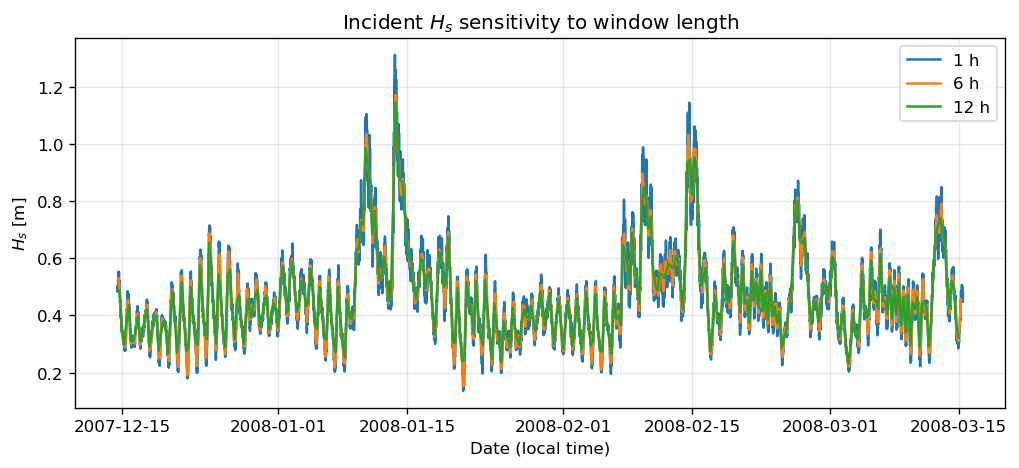

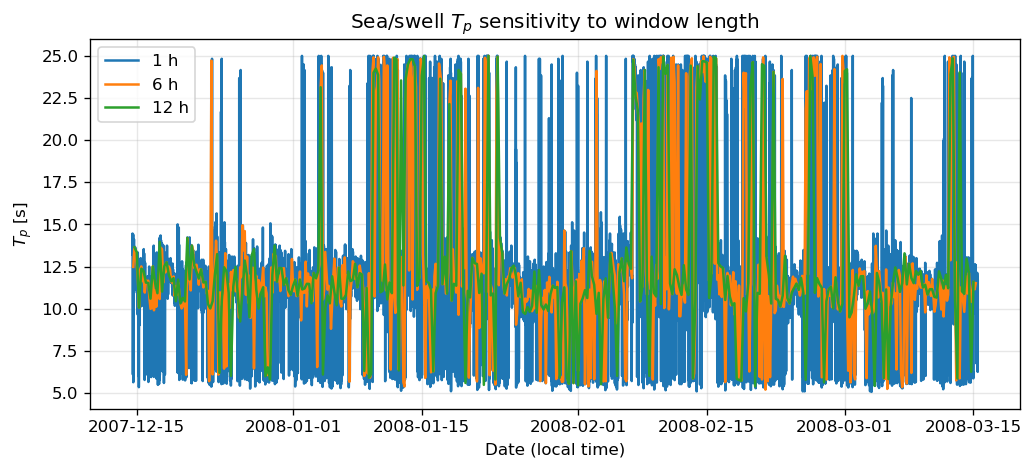

,window,win_len_samples,mean_Hs (m),std_Hs (m),mean_Tp (s),std_Tp (s),n_windows
0,1 h,1801,0.464266,0.154039,11.945518,4.879263,8828
1,6 h,10801,0.464746,0.151123,12.650109,5.082242,734
2,12 h,21601,0.465853,0.147194,12.564157,4.864302,366


In [39]:
# --- Window sensitivity: compare different spectral averaging lengths ---
import pandas as pd

configs = [
    ("1 h", 3600, 15 * 60),
    ("6 h", 6 * 3600, 3 * 3600),
    ("12 h", 12 * 3600, 6 * 3600),
]

results = {}
for label, win_len, step in configs:
    results[label] = compute_sliding_spectra(pressure_hp, depth_tide, dt=1.0, win_len=win_len, step=step)

def centers_to_datetime(centers):
    centers = np.asarray(centers)
    if np.issubdtype(centers.dtype, np.datetime64):
        arr = centers
    else:
        arr = time[0] + centers.astype('timedelta64[s]')
    return to_datetime(arr)

fig, ax = plt.subplots(figsize=(10, 4))
for label, summary in results.items():
    ax.plot(centers_to_datetime(summary['time_centers']), summary['hs_total'], label=label)
ax.set_ylabel(r'$H_s$ [m]')
ax.set_title('Incident $H_s$ sensitivity to window length')
ax.set_xlabel('Date (local time)')
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10, 4))
for label, summary in results.items():
    ax.plot(centers_to_datetime(summary['time_centers']), summary['tp_ss'], label=label)
ax.set_ylabel(r'$T_p$ [s]')
ax.set_title('Sea/swell $T_p$ sensitivity to window length')
ax.set_xlabel('Date (local time)')
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

rows = []
for label, summary in results.items():
    hs = summary['hs_total']
    tp = summary['tp_ss']
    rows.append({
        'window': label,
        'win_len_samples': summary['spectra'].shape[1],
        'mean_Hs (m)': np.nanmean(hs),
        'std_Hs (m)': np.nanstd(hs),
        'mean_Tp (s)': np.nanmean(tp),
        'std_Tp (s)': np.nanstd(tp),
        'n_windows': np.sum(np.isfinite(hs))
    })
pd.DataFrame(rows)
